# 📦 Bounding Box-Based Medical Image Analysis using Gemini

Object detection is a fundamental task in computer vision that involves identifying and localizing objects within an image using bounding boxes. Google’s Gemini models offer powerful multimodal capabilities that make this task more accessible and efficient, even without traditional training pipelines.

This tutorial demonstrates how to leverage **Gemini 2.0 Flash** and **Gemini 2.5 Pro** for object and bounding box detection using natural language prompts and images—no fine-tuning required. With just a few lines of code, you can send an image to the model and receive precise annotations for the detected objects.

### 🔍 About the Models

- **[Gemini 2.0 Flash](https://ai.google.dev/gemini-api/docs/models/gemini#gemini-2.0-flash)**: Optimized for fast, lightweight inference—ideal for interactive tasks with lower latency.
- **[Gemini 2.5 Pro](https://ai.google.dev/gemini-api/docs/models#gemini-2.5-pro-exp-03-25)**: A more powerful version, capable of handling complex multimodal prompts and providing higher-quality results for detailed object recognition.


## 🚀 Get Started with Gemini

Before diving into object detection with Gemini, you'll need to set up your environment. Follow the steps below to get started quickly:

### 🔑 Get Your Free API Key

To use Gemini models, you need an API key from **Google AI Studio**:

1. Visit [Google AI Studio](https://aistudio.google.com/app/apikey).
2. Sign in with your Google account.
3. Click on **"Create API Key"** and copy the generated key.

In [1]:
%pip install -U -q google-genai
# already installed in Colab, but for local env: pip install Pillow

In [2]:
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

In [3]:
from google import genai

client = genai.Client(api_key=GOOGLE_API_KEY)

Load test dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

!gdown --id 1NEgL9Cz37xbA5oQtwU5W5_l84mEequJr

!unzip ./test_dataset.zip
!rm -f ./test_dataset.zip

Mounted at /content/drive
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1NEgL9Cz37xbA5oQtwU5W5_l84mEequJr
To: /content/test_dataset.zip
100% 1.81M/1.81M [00:00<00:00, 13.7MB/s]
Archive:  ./test_dataset.zip
  inflating: test_dataset/alopecia.jpg  
  inflating: test_dataset/Eczema (Atopic Dermatitis).jpeg  
  inflating: test_dataset/fracture.jpg  
  inflating: test_dataset/herpes.jpg  
  inflating: test_dataset/HPV.jpg    
  inflating: test_dataset/mammogram.png  
  inflating: test_dataset/mix.jpeg   
  inflating: test_dataset/Moneypox.jpg  
  inflating: test_dataset/Onychomycosis.jpg  
  inflating: test_dataset/psoriasis.jpg  
  inflating: test_dataset/seborrheic dermatitis.png  
  inflating: test_dataset/vitiligo.jpg  



### 📷 Loading an Image

**From a URL:**
```python
from PIL import Image
import requests
from io import BytesIO

url = 'https://www.shutterstock.com/image-photo/problem-acne'
image = Image.open(BytesIO(requests.get(url).content))
```

**From a Local File:**
```python
from PIL import Image

image_path = '/content/test_dataset/alopecia.jpg'
image = Image.open(image_path)
```

In [12]:
import requests
from io import BytesIO
from PIL import Image   # for local envs, install Pillow with `pip install Pillow`
image_path = '/content/test_dataset/alopecia.jpg'
image = Image.open(image_path)

## Detect bounding boxes

Define the bounding box schema.
Note: Gemini provides bounding box coordinates in the following structure:
[top, left, bottom, right], where the values are normalized within a [0,1000] range.
- `[y_min, x_min, y_max, x_max]`
- and normalized to `[0,1000]`

Define the prompt. Here we also want the label:

In [13]:
prompt = """Detect the 2D bounding boxes of all visible skin abnormalities in the image.
Label each bounding box with the suspected skin disease type."""

In [14]:
# Define the bounding box schema.
from pydantic import BaseModel

class BoundingBox(BaseModel):
  box_2d: list[int]
  label: str



**Execute the model.**  
For best results, use `gemini-2.5-pro-exp-03-25`, which offers high performance.  
Alternatively, `gemini-2.0-flash` is a faster option that also delivers solid results.


In [15]:
response = client.models.generate_content(
    model="gemini-2.5-pro-exp-03-25", # "gemini-2.0-flash"
    contents=[prompt, image],
    config={
        'response_mime_type': 'application/json',
        'response_schema': list[BoundingBox],
    },

)

# Parse the JSON response
bounding_boxes = response.parsed
bounding_boxes

[BoundingBox(box_2d=[150, 295, 495, 623], label='Alopecia Areata'),
 BoundingBox(box_2d=[172, 616, 388, 728], label='Alopecia Areata'),
 BoundingBox(box_2d=[302, 770, 506, 843], label='Alopecia Areata')]

Draw the bounding boxes:

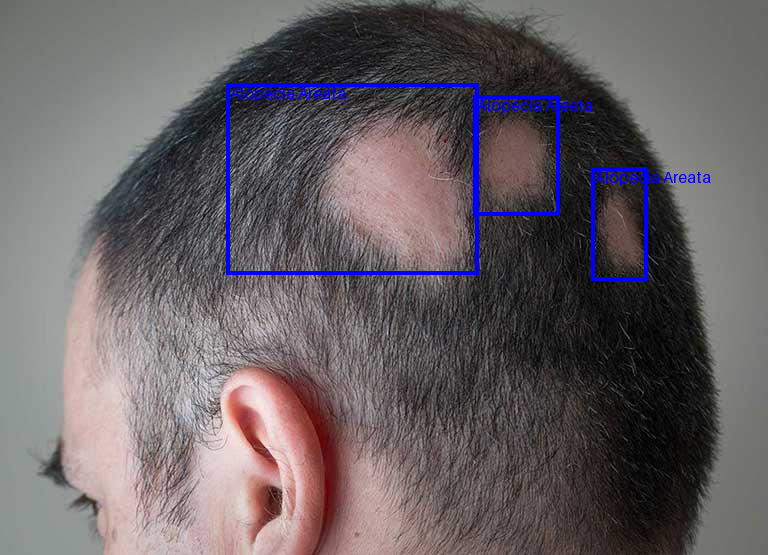

In [16]:
from PIL import ImageDraw, ImageFont

line_width = 4
font = ImageFont.load_default(size=16)

labels = list(set(box.label for box in bounding_boxes))

def draw_bounding_boxes(image, bounding_boxes):
    img = image.copy()
    width, height = img.size

    draw = ImageDraw.Draw(img)

    colors = ['blue','red','green','yellow','orange','pink','purple']

    for box in bounding_boxes:
        y_min, x_min, y_max, x_max = box.box_2d
        label = box.label

        # Convert normalized coordinates to absolute coordinates
        y_min = int(y_min/1000 * height)
        x_min = int(x_min/1000 * width)
        y_max = int(y_max/1000 * height)
        x_max = int(x_max/1000 * width)

        color = colors[labels.index(label) % len(colors)]
        draw.rectangle([(x_min, y_min), (x_max, y_max)], outline=color, width=line_width)

        draw.text((x_min+line_width, y_min), label, fill=color, font=font)

    display(img)

draw_bounding_boxes(image, bounding_boxes)

In [17]:
from PIL import Image, ImageDraw, ImageFont
from pydantic import BaseModel

def process_image_with_prompt(prompt: str, image: Image.Image):
    """
    Uses the Gemini model to detect related class bounding boxes in an image,
    then draws and displays these boxes with labels.

    Parameters:
        prompt (str): The detection prompt to be sent to the model.
        image (PIL.Image): The input image to process.
    """
    # Define the schema for bounding boxes.
    class BoundingBox(BaseModel):
        box_2d: list[int]  # Coordinates in normalized form (assumed range [0, 1000])
        label: str         # Detected  label

    # Generate bounding boxes using the Gemini model.
    response = client.models.generate_content(
        model="gemini-2.5-pro-exp-03-25",  # Alternatively, use "gemini-2.0-flash"
        contents=[prompt, image],
        config={
            'response_mime_type': 'application/json',
            'response_schema': list[BoundingBox],
        },
    )
    bounding_boxes = response.parsed
    print("Detected bounding boxes:", bounding_boxes)

    # Set drawing parameters.
    line_width = 4
    font = ImageFont.load_default()

    # Extract unique labels to assign consistent colors.
    labels = list(set(box.label for box in bounding_boxes))
    colors = ['blue', 'red', 'green', 'yellow', 'orange', 'pink', 'purple']

    # Create a copy of the image and get dimensions.
    img = image.copy()
    width, height = img.size
    draw = ImageDraw.Draw(img)

    # Iterate over each bounding box.
    for box in bounding_boxes:
        # Unpack normalized coordinates.
        y_min, x_min, y_max, x_max = box.box_2d

        # Convert normalized coordinates to absolute pixel values.
        y_min = int(y_min / 1000 * height)
        x_min = int(x_min / 1000 * width)
        y_max = int(y_max / 1000 * height)
        x_max = int(x_max / 1000 * width)

        # Choose a color based on the label.
        color = colors[labels.index(box.label) % len(colors)]

        # Draw the bounding rectangle and label text.
        draw.rectangle([(x_min, y_min), (x_max, y_max)], outline=color, width=line_width)
        draw.text((x_min + line_width, y_min), box.label, fill=color, font=font)

    # Display the image with bounding boxes.
    display(img)

Detected bounding boxes: [BoundingBox(box_2d=[437, 480, 662, 730], label='HPV warts'), BoundingBox(box_2d=[131, 413, 493, 624], label='HPV warts'), BoundingBox(box_2d=[493, 210, 592, 302], label='HPV warts'), BoundingBox(box_2d=[297, 635, 381, 725], label='HPV warts'), BoundingBox(box_2d=[290, 372, 349, 433], label='HPV warts'), BoundingBox(box_2d=[616, 247, 902, 664], label='HPV warts'), BoundingBox(box_2d=[320, 751, 363, 781], label='HPV warts')]


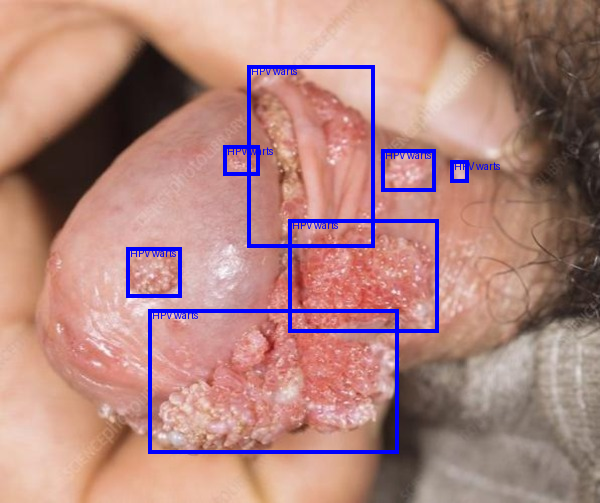

In [19]:
image_path = '/content/test_dataset/HPV.jpg'
image = Image.open(image_path)

prompt = """
Detect the 2D bounding boxes of all visible signs of STDs in the clinical image.
Label each bounding box with the suspected STD type (e.g., herpes, syphilis, HPV warts).
Note: For discharge-related STDs like gonorrhea or chlamydia, attempt detection only if discharge is clearly visible.
"""

process_image_with_prompt(prompt, image)

Detected bounding boxes: [BoundingBox(box_2d=[112, 328, 229, 439], label='herpes'), BoundingBox(box_2d=[155, 592, 263, 717], label='herpes'), BoundingBox(box_2d=[291, 493, 453, 675], label='herpes'), BoundingBox(box_2d=[590, 95, 788, 227], label='herpes'), BoundingBox(box_2d=[103, 453, 180, 515], label='herpes')]


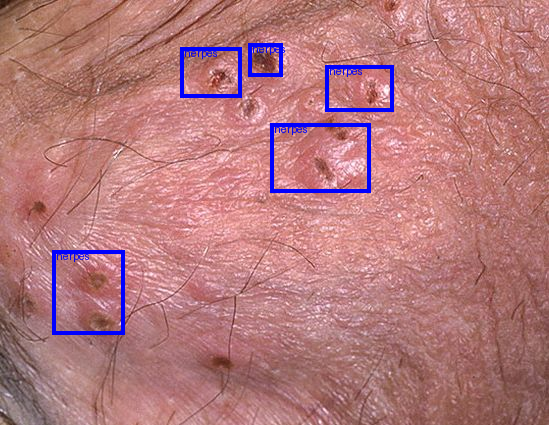

In [23]:
image_path = '/content/test_dataset/herpes.jpg'
image = Image.open(image_path)

prompt = """
Detect the 2D bounding boxes of all visible signs of STDs in the clinical image.
Label each bounding box with the suspected STD type (e.g., herpes, syphilis, HPV warts).
Note: For discharge-related STDs like gonorrhea or chlamydia, attempt detection only if discharge is clearly visible.
"""

process_image_with_prompt(prompt, image)

Detected bounding boxes: [BoundingBox(box_2d=[130, 122, 727, 733], label='suspicious')]


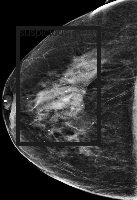

In [22]:
image_path = '/content/test_dataset/mammogram.png'
image = Image.open(image_path)

prompt = """Detect and localize any suspicious areas in the mammogram using 2D bounding boxes.
Label each region as 'suspicious' or 'normal' based on visual patterns."""

process_image_with_prompt(prompt, image)

Detected bounding boxes: [BoundingBox(box_2d=[297, 350, 705, 618], label='onychomycosis')]


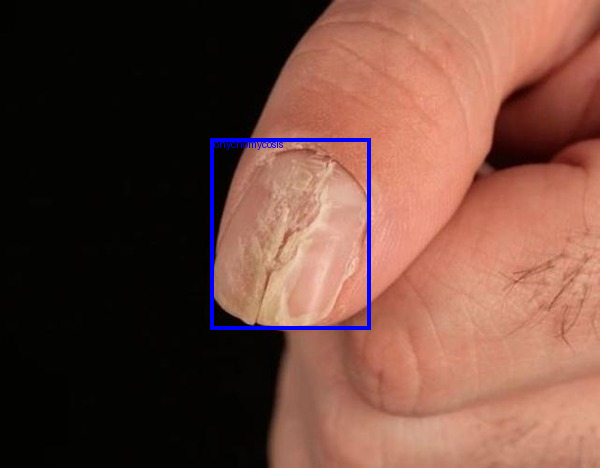

In [24]:
image_path = '/content/test_dataset/Onychomycosis.jpg'
image = Image.open(image_path)

prompt = """Detect the 2D bounding boxes of all nail disease symptoms in the image.
Each bounding box should be labeled with the disease type."""

process_image_with_prompt(prompt, image)

Detected bounding boxes: [BoundingBox(box_2d=[134, 178, 170, 214], label='Mpox lesion - pustule'), BoundingBox(box_2d=[359, 355, 383, 382], label='Mpox lesion - papule'), BoundingBox(box_2d=[479, 230, 510, 262], label='Mpox lesion - papule'), BoundingBox(box_2d=[530, 115, 570, 174], label='Mpox lesion - pustule'), BoundingBox(box_2d=[547, 677, 619, 777], label='Mpox lesion - pustule'), BoundingBox(box_2d=[972, 269, 1000, 306], label='Mpox lesion - papule'), BoundingBox(box_2d=[64, 709, 121, 761], label='Mpox lesion - pustule'), BoundingBox(box_2d=[85, 952, 125, 994], label='Mpox lesion - pustule'), BoundingBox(box_2d=[127, 954, 158, 982], label='Mpox lesion - papule')]


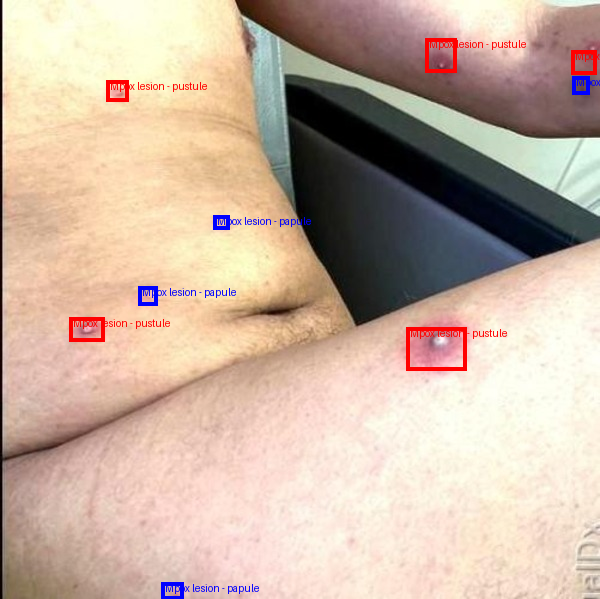

In [25]:
image_path = '/content/test_dataset/Moneypox.jpg'
image = Image.open(image_path)

prompt = """Detect the 2D bounding boxes of all visible Mpox (Monkeypox) lesions in the clinical image.
Each bounding box should be labeled as 'Mpox lesion' and, if possible, include the lesion stage (e.g., macule, papule, vesicle, pustule, scab)."""

process_image_with_prompt(prompt, image)

Detected bounding boxes: [BoundingBox(box_2d=[219, 179, 575, 337], label='oblique'), BoundingBox(box_2d=[309, 256, 499, 324], label='oblique'), BoundingBox(box_2d=[444, 658, 625, 705], label='oblique'), BoundingBox(box_2d=[478, 738, 664, 839], label='oblique')]


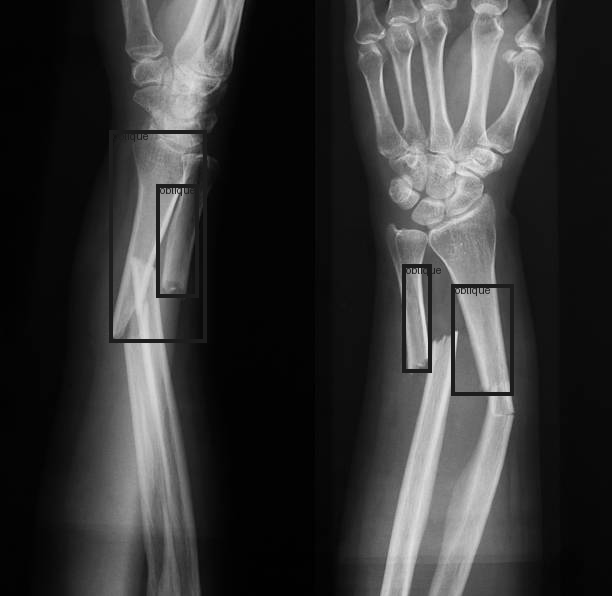

In [26]:
image_path = '/content/test_dataset/fracture.jpg'

image = Image.open(image_path)
prompt = """Detect the 2D bounding boxes of all visible bone fractures in the image.
Label each bounding box with the type of fracture (e.g., transverse, oblique, spiral, comminuted)"""

process_image_with_prompt(prompt, image)

Detected bounding boxes: [BoundingBox(box_2d=[87, 350, 431, 755], label='psoriasis'), BoundingBox(box_2d=[652, 526, 969, 793], label='psoriasis'), BoundingBox(box_2d=[573, 350, 676, 441], label='psoriasis'), BoundingBox(box_2d=[471, 705, 545, 773], label='psoriasis'), BoundingBox(box_2d=[321, 107, 780, 322], label='psoriasis'), BoundingBox(box_2d=[766, 249, 866, 315], label='psoriasis'), BoundingBox(box_2d=[888, 394, 947, 462], label='psoriasis'), BoundingBox(box_2d=[852, 215, 930, 268], label='psoriasis'), BoundingBox(box_2d=[833, 389, 950, 468], label='psoriasis'), BoundingBox(box_2d=[697, 236, 759, 281], label='psoriasis'), BoundingBox(box_2d=[607, 294, 669, 341], label='psoriasis'), BoundingBox(box_2d=[466, 443, 516, 488], label='psoriasis'), BoundingBox(box_2d=[421, 379, 466, 410], label='psoriasis'), BoundingBox(box_2d=[302, 319, 366, 377], label='psoriasis'), BoundingBox(box_2d=[209, 309, 285, 367], label='psoriasis'), BoundingBox(box_2d=[169, 208, 300, 273], label='psoriasis'),

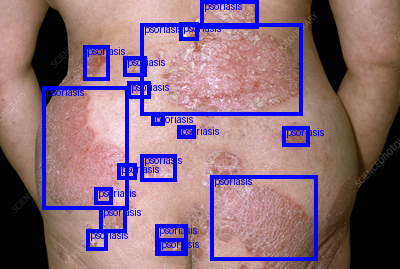

In [27]:
image_path = '/content/test_dataset/psoriasis.jpg'

image = Image.open(image_path)

prompt = """Detect the 2D bounding boxes of all visible skin abnormalities in the image.
Label each bounding box with the suspected skin disease type (e.g., eczema, psoriasis, acne, melanoma, vitiligo, rosacea, fungal infection)."""

process_image_with_prompt(prompt, image)

Detected bounding boxes: [BoundingBox(box_2d=[97, 37, 375, 267], label='Vitiligo'), BoundingBox(box_2d=[383, 277, 529, 395], label='Vitiligo'), BoundingBox(box_2d=[756, 125, 902, 240], label='Vitiligo'), BoundingBox(box_2d=[809, 337, 892, 400], label='Vitiligo'), BoundingBox(box_2d=[256, 327, 339, 392], label='Vitiligo'), BoundingBox(box_2d=[187, 435, 312, 500], label='Vitiligo'), BoundingBox(box_2d=[136, 640, 402, 767], label='Vitiligo'), BoundingBox(box_2d=[395, 820, 541, 947], label='Vitiligo'), BoundingBox(box_2d=[460, 950, 534, 1000], label='Vitiligo'), BoundingBox(box_2d=[568, 797, 690, 915], label='Vitiligo'), BoundingBox(box_2d=[785, 937, 882, 1000], label='Vitiligo'), BoundingBox(box_2d=[841, 675, 997, 817], label='Vitiligo'), BoundingBox(box_2d=[95, 795, 182, 867], label='Vitiligo')]


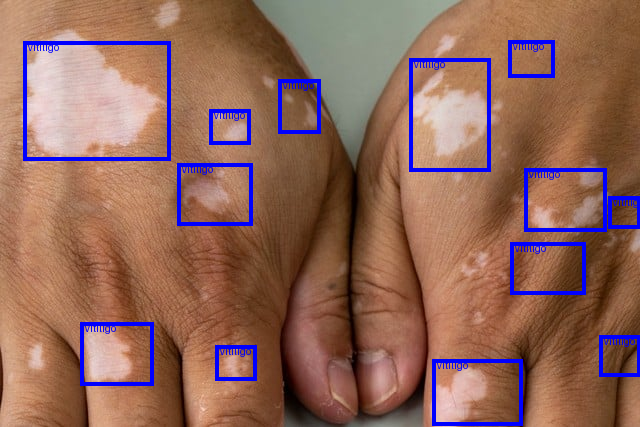

In [28]:
image_path = '/content/test_dataset/vitiligo.jpg'

image = Image.open(image_path)

prompt = """Detect the 2D bounding boxes of all visible skin abnormalities in the image.
Label each bounding box with the suspected skin disease type."""

process_image_with_prompt(prompt, image)

Detected bounding boxes: [BoundingBox(box_2d=[341, 278, 682, 859], label='Eczema')]


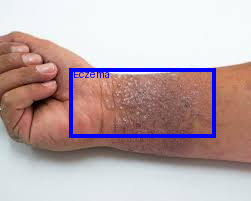

In [30]:
image_path = '/content/test_dataset/Eczema (Atopic Dermatitis).jpeg'

image = Image.open(image_path)

prompt = """Detect the 2D bounding boxes of all visible skin abnormalities in the image.
Label each bounding box with the suspected skin disease type."""

process_image_with_prompt(prompt, image)

Detected bounding boxes: [BoundingBox(box_2d=[260, 332, 325, 401], label='Dandruff or Seborrheic Dermatitis'), BoundingBox(box_2d=[260, 418, 320, 466], label='Dandruff or Seborrheic Dermatitis'), BoundingBox(box_2d=[378, 149, 427, 212], label='Dandruff or Seborrheic Dermatitis'), BoundingBox(box_2d=[417, 138, 537, 260], label='Dandruff or Seborrheic Dermatitis'), BoundingBox(box_2d=[478, 156, 542, 207], label='Dandruff or Seborrheic Dermatitis'), BoundingBox(box_2d=[545, 199, 617, 287], label='Dandruff or Seborrheic Dermatitis'), BoundingBox(box_2d=[409, 393, 456, 431], label='Dandruff or Seborrheic Dermatitis'), BoundingBox(box_2d=[521, 411, 566, 447], label='Dandruff or Seborrheic Dermatitis'), BoundingBox(box_2d=[630, 679, 667, 720], label='Dandruff or Seborrheic Dermatitis'), BoundingBox(box_2d=[745, 599, 792, 647], label='Dandruff or Seborrheic Dermatitis'), BoundingBox(box_2d=[804, 455, 851, 492], label='Dandruff or Seborrheic Dermatitis')]


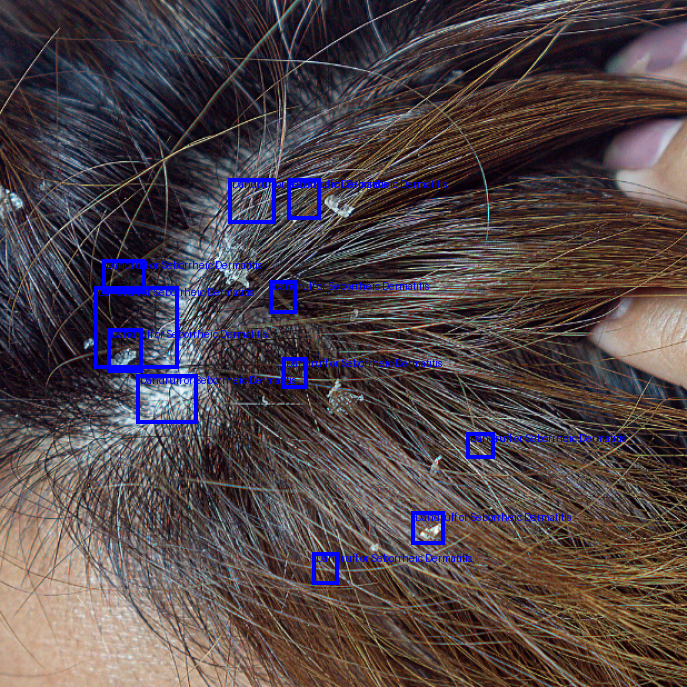

In [32]:
image_path = '/content/test_dataset/seborrheic dermatitis.png'

image = Image.open(image_path)

prompt = """Detect the 2D bounding boxes of all visible skin abnormalities in the image.
Label each bounding box with the suspected skin disease type."""

process_image_with_prompt(prompt, image)

Detected bounding boxes: [BoundingBox(box_2d=[5, 2, 367, 450], label='Acne'), BoundingBox(box_2d=[41, 569, 339, 891], label='Psoriasis'), BoundingBox(box_2d=[510, 34, 868, 374], label='Psoriasis'), BoundingBox(box_2d=[584, 647, 791, 907], label='Eczema/Dermatitis')]


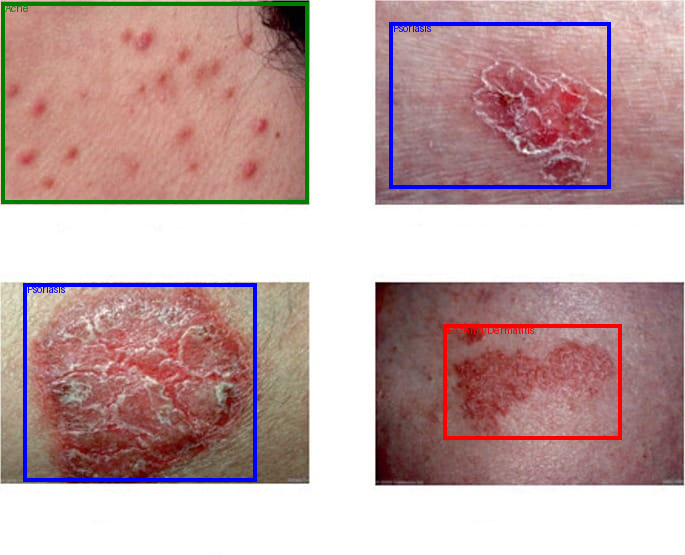

In [35]:
image_path = '/content/test_dataset/mix.jpeg'

image = Image.open(image_path)

prompt = """Detect the 2D bounding boxes of all visible skin abnormalities in the image.
Label each bounding box with the suspected skin disease type."""

process_image_with_prompt(prompt, image)